In [ ]:
import os
import sys
sys.path.append('/home/iburenko/SimCLR/')
sys.path.append('/home/iburenko/timm/')
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
#from loader import PETDataset, TransformsSimCLR
from timm import create_model, list_models
from simclr import SimCLR
from simclr.modules import NT_Xent, LARS
from transformers import BertTokenizerFast
from tqdm import tqdm
import umap
from torch.utils.data import DataLoader, Dataset
from itertools import combinations_with_replacement
import cv2
import torchvision
from torch import nn, optim
import argparse
import time
import torchvision.transforms as transforms
from timm import create_model
from PIL import Image, ImageOps, ImageFilter
from torch.utils.tensorboard import SummaryWriter
import math
import json
import torch
from torch.utils.data import Dataset
import torchvision
import numpy as np
from tqdm import tqdm
import cv2
import random

## класс для данных с аугментациями (для тренировки)

In [ ]:
class PETDataset(Dataset):
    def __init__(self, train, size=64, transform = True):
        assert train in ['train', 'val']
        self.train = train
        self.resize = torchvision.transforms.Resize(size=size)
        with open('train_val_split.json', 'r') as file:
            self.image_filenames = json.load(file)[train]
        self.all_lens = [len(val) for val in self.image_filenames.values()]
        self.cumsum = np.array([sum(self.all_lens[:i]) for i in range(len(self.all_lens)+1)])
        self.transform = transform
    
    def __len__(self):
        return self.cumsum[-1]

    def __getitem__(self, idx):
        case_id = (idx >= self.cumsum).sum() - 1
        key = list(self.image_filenames.keys())[case_id]
        slice_id = idx - self.cumsum[case_id]
        im = cv2.imread(key+'/'+self.image_filenames[key][slice_id])
        #print(key+'/'+self.image_filenames[key][slice_id])
        #print(im.shape)
        #print(im.type())
        
        im = np.moveaxis(im, -1, 0)
        
        im = self.resize(torch.from_numpy(im))
        im = im.numpy()
        im1 = Image.fromarray((im[1] * 255).astype(np.uint8))
        #print(im1)
        #print(im[1].type())
        
        if self.transform:
            pic1, pic2 = self.transform(im1)
        
        return self._normalize(pic1.reshape(256, 256), 'ct'), self._normalize(pic2.reshape(256, 256), 'ct')
    
    def _normalize(self, image, mode):
        assert mode in ['ct', 'pet']
        mean = 69.1 if mode == 'ct' else 4.7
        std = 55.6 if mode == 'ct' else 18.1
        return (image-mean)/std

## класс для данных без аугментаций (для теста)

In [ ]:
class PETDataset(Dataset):
    def __init__(self, train, size=64, transform = False):
        assert train in ['train', 'val']
        self.train = train
        self.resize = torchvision.transforms.Resize(size=size)
        with open('train_val_split.json', 'r') as file:
            self.image_filenames = json.load(file)[train]
        self.all_lens = [len(val) for val in self.image_filenames.values()]
        self.cumsum = np.array([sum(self.all_lens[:i]) for i in range(len(self.all_lens)+1)])
        self.transform = transform
    
    def __len__(self):
        return self.cumsum[-1]

    def __getitem__(self, idx):
        case_id = (idx >= self.cumsum).sum() - 1
        key = list(self.image_filenames.keys())[case_id]
        slice_id = idx - self.cumsum[case_id]
        im = cv2.imread(key+'/'+self.image_filenames[key][slice_id])
        #print(key+'/'+self.image_filenames[key][slice_id])
        #print(im.shape)
        #print(im.type())
        
        im = np.moveaxis(im, -1, 0)
        
        im = self.resize(torch.from_numpy(im))
      
        #print(im1)
        #print(im[1].type())
        
        if self.transform:
            pic1, pic2 = self.transform(im1)
        
        return self._normalize(im[1], 'ct'), self._normalize(im[1], 'сt')
    
    def _normalize(self, image, mode):
        assert mode in ['ct', 'pet']
        mean = 69.1 if mode == 'ct' else 4.7
        std = 55.6 if mode == 'ct' else 18.1
        return (image-mean)/std

## Функции для ф. потерь и коррекции lerning rate

In [ ]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def adjust_learning_rate(epochs, optimizer, loader, step):
#     max_steps = epochs * len(loader)
#     warmup_steps = 10 * len(loader)
#     base_lr = 32 / 256
#     if step < warmup_steps:
#         lr = base_lr * step / warmup_steps
#     else:
#         step -= warmup_steps
#         max_steps -= warmup_steps
#         q = 0.5 * (1 + math.cos(math.pi * step / max_steps))
#         end_lr = base_lr * 0.001
#         lr = base_lr * q + end_lr * (1 - q)
    lr = 1
    optimizer.param_groups[0]['lr'] = lr * 0.2
    optimizer.param_groups[1]['lr'] = lr * 0.0048

## Barlow twins

In [ ]:
class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.backbone = torchvision.models.resnet50(zero_init_residual=True)
        self.backbone = create_model('wide_resnet50_2', in_chans=1, pretrained=True)
        self.backbone.fc = nn.Identity()
        print(sum(p.numel() for p in self.backbone.parameters() if p.requires_grad))
        # projector
        #sizes = [2048] + list(map(int, '8192-8192-8192'.split('-')))
        layers = []

        #for i in range(len(sizes) - 2):
        layers.append(nn.Linear(2048, 4096, bias=False))
        x1 = nn.Linear(2048, 4096, bias=False)
        print(x1)
        layers.append(nn.BatchNorm1d(4096))
        x2 = nn.BatchNorm1d(4096)
        print(x2)
        layers.append(nn.ReLU(inplace=True))
        x3 = nn.ReLU(inplace=True)
        print(x3)
            
      
        layers.append(nn.Linear(4096, 2048, bias=False))
        x4 = nn.Linear(4096, 2048, bias=False)
        print(x4)
        self.projector = nn.Sequential(*layers)
        print(self.projector)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(2048, affine=False)

    def forward(self, y1, y2):
        #print('y1', y1.size())
        #print('y2', y2.size())
        z1 = self.projector(self.backbone(y1))
        z2 = self.projector(self.backbone(y2))
        #print('z1', z1.size())
        #print('z2', z2.size())

        # empirical cross-correlation matrix
        c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        c.div_(4)
        #torch.distributed.all_reduce(c)

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        #print('on_diag', on_diag)
        off_diag = off_diagonal(c).pow_(2).sum()
        #print('off_diag', off_diag)
        loss = on_diag + 0.0051 * off_diag / 100000
        
        return loss#, on_diag, off_diag/10000
    
    def get_reps(self, y1, y2):
        
        z1 = self.projector(self.backbone(y1))
        z2 = self.projector(self.backbone(y2))
  
        return z1, z2

In [ ]:
class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.backbone = create_model('wide_resnet50_2', in_chans=1, pretrained=True)
        self.backbone.fc = nn.Identity()

        # projector
        sizes = [2048] + list(map(int, '8192-8192-8192'.split('-')))
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
      
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, y1, y2):
   
        z1 = self.projector(self.backbone(y1))
        z2 = self.projector(self.backbone(y2))

        # empirical cross-correlation matrix
        c = self.bn(z1).T @ self.bn(z2)

        # sum the cross-correlation matrix between all gpus
        c.div_(4)
        #torch.distributed.all_reduce(c)

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = on_diag + 0.0051 * off_diag / 100000
        
    def get_reps(self, y1, y2):
        
        z1 = self.projector(self.backbone(y1))
        z2 = self.projector(self.backbone(y2))
        
        return z1, z2

In [ ]:
net = create_model('wide_resnet50_2', in_chans=1, pretrained=True)
net.fc = nn.Identity()
ne = net.to(device)
y1 = y1.to(device)
print(ne(y1).size())

## Optimizer Lars

In [ ]:
class LARS(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, momentum=0.9, eta=0.001,
                 weight_decay_filter=False, lars_adaptation_filter=False):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,
                        eta=eta, weight_decay_filter=weight_decay_filter,
                        lars_adaptation_filter=lars_adaptation_filter)
        super().__init__(params, defaults)


    def exclude_bias_and_norm(self, p):
        return p.ndim == 1

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if not g['weight_decay_filter'] or not self.exclude_bias_and_norm(p):
                    #print(p.shape)
                    dp = dp.add(p, alpha=g['weight_decay'])

                if not g['lars_adaptation_filter'] or not self.exclude_bias_and_norm(p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                                (g['eta'] * param_norm / update_norm), one), one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)

                p.add_(mu, alpha=-g['lr'])

## Augmentations

In [ ]:
class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            #transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
            #transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomApply(
#                 [transforms.ColorJitter(brightness=0.4, contrast=0.4,
#                                         saturation=0.2, hue=0.1)],
#                 p=0.8
#             ),
            #transforms.RandomGrayscale(p=0.2),
            #GaussianBlur(p=0.0),
            Solarization(p=0.0),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 #std=[0.229, 0.224, 0.225])
        ])
        self.transform_prime = transforms.Compose([
            #transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
            #transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomApply(
#                 [transforms.ColorJitter(brightness=0.4, contrast=0.4,
#                                         saturation=0.2, hue=0.1)],
#                 p=0.8
#             ),
            #transforms.RandomGrayscale(p=0.2),
            #GaussianBlur(p=1.0),
            Solarization(p=1.0),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                # std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return y1, y2

## подготовка к оучению и т.д.

In [ ]:
device = torch.device('cuda:1')
model = BarlowTwins().to(device)
param_weights = []
param_biases = []
for param in model.parameters():
    if param.ndim == 1:
        param_biases.append(param)
    else:
        param_weights.append(param)
parameters = [{'params': param_weights}, {'params': param_biases}]

optimizer = LARS(parameters, lr=0, weight_decay=1e-6,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

dataset = PETDataset('val', 256)

dataloader = DataLoader(dataset, batch_size=4, num_workers=1)

scaler = torch.cuda.amp.GradScaler()

#writer = SummaryWriter()

In [ ]:
count_parameters(model)

NameError: name 'count_parameters' is not defined

In [ ]:
(dataset[0][0] - dataset[0][0]).sum()

AssertionError: 

In [ ]:
len(dataset)

3206

## Сами картинки КТ и КТ в данном случае

In [ ]:
plt.imshow(dataset[10][0])

NameError: name 'dataset' is not defined

In [ ]:
plt.imshow(dataset[10][1])

AssertionError: 

In [ ]:
for epoch in range(50):
    epoch_loss = 0
    for step, (y1, y2) in enumerate(dataloader, start=len(dataloader)):
        
#         y1 = y1.unsqueeze(1)
#         y2 = y2.unsqueeze(1)
        
#         y1, y2 = y1.to(device), y2.to(device)
# #         print(y1)
# #         print(y2)
# #         print(y1.shape)
# #         print(y2.shape)
        
#         adjust_learning_rate(50, optimizer, dataloader, step)
#         optimizer.zero_grad()
        
#         with torch.cuda.amp.autocast():
#             loss = model.forward(y1, y2)

#         scaler.scale(loss).backward()
        
#         #nn.utils.clip_grad_norm_(model.parameters(), 1)
        
#         scaler.step(optimizer)
#         scaler.update()
        
#         epoch_loss += loss.item()
        print(step)
        
        if step%801 == 0 and step != 0:
            break
    
    
    #writer.add_scalar('Loss/Epoch', epoch_loss/len(dataloader), epoch)
    
    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(dataloader):.5f}')
    
    #torch.save(model.state_dict(), '/data/fzhukov/weights_clip/resnet{}.pth'.format(epoch))
    
#writer.close()

In [ ]:
batch = next(iter(dataloader))
batch[0] = batch[0].unsqueeze(1).to(device)
batch[1] = batch[1].unsqueeze(1).to(device)
final = model(*batch)
print(final)

/home/fzhukov/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(10651.7295, device='cuda:1', grad_fn=<AddBackward0>)


In [ ]:
batch = next(iter(dataloader))
batch[0] = batch[0].unsqueeze(1).to(device)
batch[1] = batch[1].unsqueeze(1).to(device)
final = model(*batch)
print(final)

tensor(1.1325e+13, device='cuda:1', grad_fn=<AddBackward0>)


## Подгрузка весов

In [ ]:
_ = model.load_state_dict(torch.load('/data/fzhukov/weights_200/resnet484.pth'))

_ = model.eval()

In [ ]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

83613376

In [ ]:
device = torch.device('cuda:3')
model = model.to(device)

# Get emdeddings и формирование из них massive

In [ ]:
arr = []
ct = []
coun = 0
for step, (y1, y2) in enumerate(dataloader, start=len(dataloader)):
    y1 = y1.unsqueeze(1)
    y2 = y2.unsqueeze(1)
    plt.imshow
    y1, y2 = y1.to(device), y2.to(device)
    
    rep1, rep2 = model.get_reps(y1, y2)
    #print(reps)
    
#     print(rep1)
#     print(rep2)
    for i in range(len(rep1)):
        arr.append(rep1[i].to('cpu').detach().numpy())
    #coun += 1

    for i in range(len(rep2)):
        ct.append(rep2[i].to('cpu').detach().numpy())
        
#     arr.append(rep1.to('cpu').detach().numpy())
#     arr.append(rep2.to('cpu').detach().numpy())
    #print(arr)
        
#         for j in range(len(reps[i])):
#             arr.append(reps[i][j].to('cpu').detach().numpy())
        #print(i.to('cpu').detach().numpy().reshape(-1).tolist())
    
#print(arr.type())

mat1 = np.array(arr)
mat2 = np.array(ct)

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/fzhukov/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/fzhukov/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/fzhukov/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-2-38d08ddeab04>", line 34, in __getitem__
    return self._normalize(im[1], 'ct'), self._normalize(im[1], 'сt')
  File "<ipython-input-2-38d08ddeab04>", line 37, in _normalize
    assert mode in ['ct', 'pet']
AssertionError


## нормализирую mat1 и mat2, то есть каждую строку(вектор) делю на длину(этого вектора)

In [ ]:
l2norm = np.sqrt((mat1 * mat1).sum(axis=1))
mat1 = (mat1 / l2norm.reshape(55435,1))

In [ ]:
l2norm = np.sqrt((mat2 * mat2).sum(axis=1))
mat2 = (mat2 / l2norm.reshape(55435,1))

## Умнажаю mat1 на mat2 получаю тем самым матрицу косинусов

In [ ]:
cosines = mat1 @ mat2.T

In [ ]:
cosines[1500][1400]

0.9999319

## Сама матрица косинусов. Самый адыкватный результат by the way

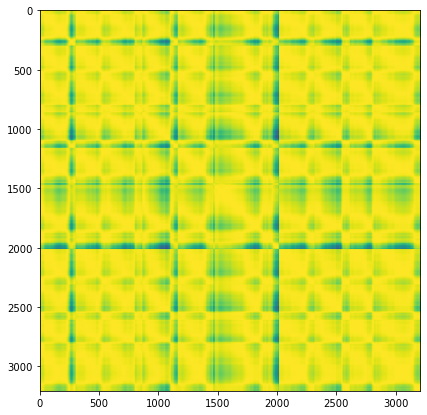

In [ ]:
plt.figure(figsize = (10,7))
plt.imshow(cosines)

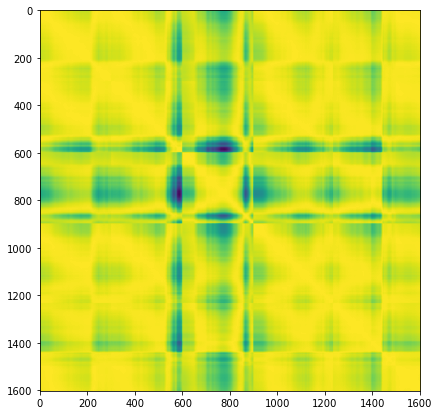

In [ ]:
plt.figure(figsize = (10,7))
plt.imshow(cosines[:1602, :1602])

## Это хуже

In [ ]:
plt.figure(figsize = (10,7))
plt.imshow(cosines)

NameError: name 'plt' is not defined

In [ ]:
lvec = []
for i in range(len(mat1)):
    length = 0
    for j in range(len(mat1[i])):
        length = length + mat1[i][j]**2
    length = float(math.sqrt(length))
    lvec.append(length)

In [ ]:
lvec = []
for i in range(len(mat2)):
    length = 0
    for j in range(len(mat2[i])):
        length = length + mat2[i][j]**2
    length = float(math.sqrt(length))
    lvec.append(length)

In [ ]:
np.sqrt((mat1).sum(axis=1))

<ipython-input-67-e471c43c68d6>:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((mat1).sum(axis=1))


array([ 5.7822886,  5.9875445,  5.030459 , ..., 11.2627   , 10.993691 ,
       10.996607 ], dtype=float32)

In [ ]:
lvec = []
for i in range(len(arr)):
    length = 0
    for j in range(len(mat1[i])):
        length = length + mat1[i][j]**2
    length = float(math.sqrt(length))
    lvec.append(length)

In [ ]:
mat2

array([[ 0.00140004, -0.00965646, -0.01214451, ..., -0.00484837,
        -0.00831127, -0.01411761],
       [ 0.00139022, -0.00965372, -0.01214528, ..., -0.00484323,
        -0.00831245, -0.01412037],
       [ 0.00137745, -0.0096499 , -0.01214699, ..., -0.00483584,
        -0.00831518, -0.01412475],
       ...,
       [ 0.00145111, -0.00971305, -0.01208674, ..., -0.0050292 ,
        -0.00824572, -0.01411433],
       [ 0.001438  , -0.0097064 , -0.01208614, ..., -0.00501915,
        -0.0082521 , -0.01411781],
       [ 0.00143948, -0.00970615, -0.01208513, ..., -0.00502066,
        -0.00824917, -0.01411686]], dtype=float32)

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
print(unit_vector(mat1[0]))

[-0.0163022   0.00522588  0.01254794 ...  0.00306979  0.00408429
  0.00489598]


In [ ]:
mat1 = torch.from_numpy(mat1)
mat2 = torch.from_numpy(mat2)

cosines = np.empty([3206, 3206])
for i in range(len(mat1)):
    for j in range(len(mat2)):
        vec1 = unit_vector(mat1[i])
        vec2 = unit_vector(mat2[j])
        cosines[i][j] = nn.CosineSimilarity(dim=0)(vec1, vec2)

In [ ]:
cosines[i][j] = (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))

In [ ]:
cosines1 = np.empty([3206, 3206])
for i in range(len(mat1)):
    for j in range(len(mat2)):
        vec1 = unit_vector(mat1[i])
        vec2 = unit_vector(mat2[j])
        cosines1[i][j] = torch.nn.CosineSimilarity(dim = 0)(torch.from_numpy(mat1[i]), torch.from_numpy(mat2[j]))

In [ ]:
torch.nn.CosineSimilarity(dim = 0)(torch.from_numpy(mat1[100]), torch.from_numpy(mat2[200]))

tensor(0.5895)

In [ ]:
def cos_between(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [ ]:
nn.CosineSimilarity(dim=1)(mat1, mat2)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

## результаты not good at all

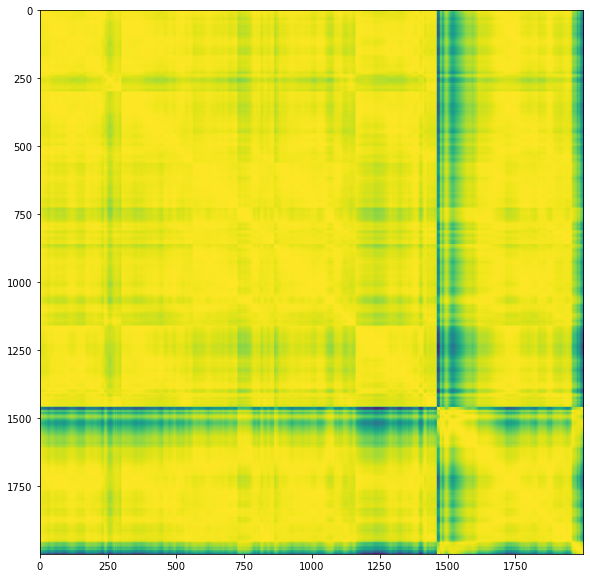

In [ ]:
plt.figure(figsize = (30,10))
plt.imshow(cosines[:2000, :2000])

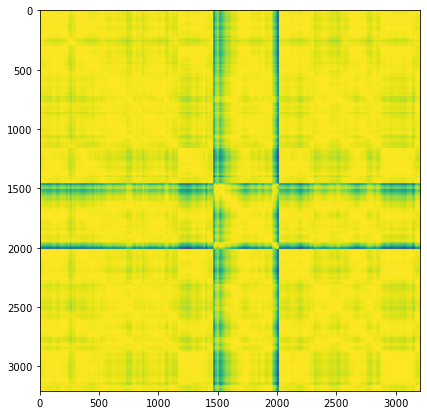

In [ ]:
plt.figure(figsize = (10,7))
plt.imshow(cosines)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

#X = np.array(final.to("cpu").detach().numpy())
clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(mat)
print(clustering)

print(clustering.labels_)


AgglomerativeClustering(n_clusters=4)
[1 1 1 ... 0 0 0]


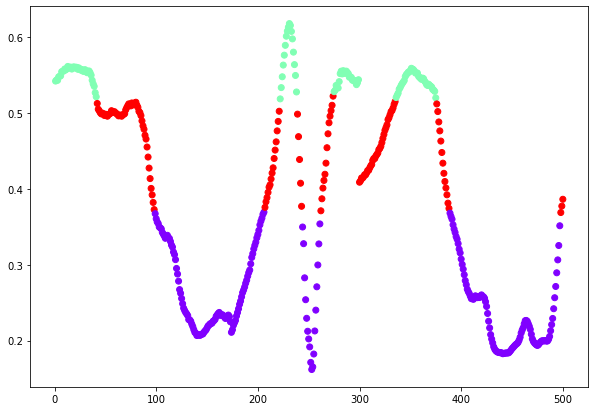

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x[0:500], lvec[0:500], c=clustering.labels_[0:500], cmap='rainbow')

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(lvec, method='ward'))

## Training

In [ ]:
for epoch in range(20):
    epoch_loss = 0
    for step, (y1, y2) in enumerate(dataloader, start=epoch * len(dataloader)):
        
        y1 = y1.unsqueeze(1)
        y2 = y2.unsqueeze(1)
        
        y1, y2 = y1.to(device), y2.to(device)
#         print(y1)
#         print(y2)
#         print(y1.shape)
#         print(y2.shape)
        
        adjust_learning_rate(20, optimizer, dataloader, step)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            loss = model.forward(y1, y2)

        scaler.scale(loss).backward()
        
        #nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
    
    #writer.add_scalar('Loss/Epoch', epoch_loss/len(dataloader), epoch)
    
    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(dataloader):.5f}')
    
    #torch.save(model.state_dict(), '/data/fzhukov/weights_clip/resnet{}.pth'.format(epoch))
    
#writer.close()

Epoch 000: | Loss: 3.81331
Epoch 001: | Loss: 3.80183
Epoch 002: | Loss: 3.80514
Epoch 003: | Loss: 3.81348
Epoch 004: | Loss: 3.79976
Epoch 005: | Loss: 3.80619
Epoch 006: | Loss: 3.80939
Epoch 007: | Loss: 3.81527
Epoch 008: | Loss: 3.81099
Epoch 009: | Loss: 3.80553
Epoch 010: | Loss: 3.80623
Epoch 011: | Loss: 3.79985


KeyboardInterrupt: 